<a href="https://colab.research.google.com/github/jkierzkowski/physics/blob/main/network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from matplotlib.animation import FuncAnimation
import pylab as pl
from matplotlib.pyplot import pause
import scipy.sparse as sp
from collections import defaultdict

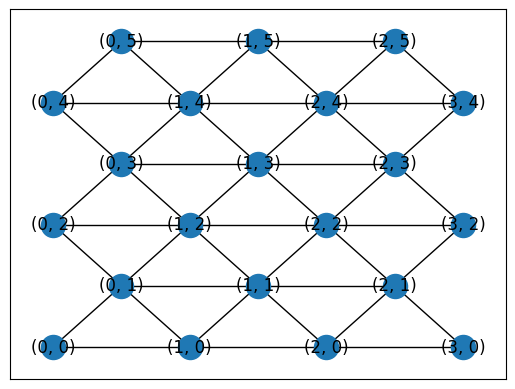

In [ ]:
n = 5
m = 5
triag = nx.triangular_lattice_graph(m,n,with_positions=True)
pos = dict(triag.nodes.data("pos"))
nx.draw_networkx(triag,pos=pos)

In [ ]:
def adjacency_matrix(all_nodes, edges):
    A = np.zeros((len(edges), len(all_nodes)))
    for i, e in enumerate(edges):
        A[i][all_nodes.index(e[0])] = 1
        A[i][all_nodes.index(e[1])] = 1
    return A

def choose_e2(e0, e1):
  return (np.sign(e0) != np.sign(e1)).nonzero()[0]

def parallel(D):
  A = np.sign(D)
  sorted_idx = np.lexsort(A.T)
  sorted_A = A[sorted_idx]
  diff = np.diff(sorted_A, axis=0)
  duplicate_indices = np.where(np.all(diff == 0, axis=1))[0]
  if duplicate_indices.size == 0:
    return []
  return np.argwhere(np.all(A == sorted_A[duplicate_indices][:, None, :], axis=2))
def merge_edges(e0, e1, D):
    d0, d1 = D[e0][D[e0] != 0], D[e1][D[e1] != 0]
    if d0.size == 0 or d1.size == 0:
        return D
    e2 = choose_e2(D[e0][0], D[e1][0])
    if e2.size == 0:
        D[e0] += d1[0] * np.sign(D[e0])
        D[e1] = 0
        return D
    D[e0] += d1[0] * np.sign(D[e0])
    D[e1] = 0
    D[:, e2[0]] += D[:, e2[1]]
    D[:, e2[1]] = 0
    D[np.count_nonzero(D, axis=1) == 1] = 0
    return D

def length(n1, n2):
    return np.sqrt((n1[0] - n2[0]) ** 2 + (n1[1] - n2[1]) ** 2)

def merging_matrix_gen(arr, posl, idx=[]):
    len_list, out, idx_list = [], [], []
    for i in range(arr.shape[1]):
        edges_from_node = arr[arr[:, i] != 0]
        sum_row, len_row, idx_row = [], [], []
        for e0 in edges_from_node[:-1]:
            for e1 in edges_from_node[1:]:
                indices = choose_e2(e0, e1)
                if indices.size == 2 and np.any((arr[:, indices[0]] != 0) & (arr[:, indices[1]] != 0)):
                    sum_row.append(e0[e0 != 0][0] + e1[e1 != 0][0])
                    len_row.append(length(posl[indices[0]][1], posl[indices[1]][1]))
                    idx_row.append((np.where((arr == e0).all(axis=1))[0], np.where((arr == e1).all(axis=1))[0]))
        len_list.append(len_row)
        out.append((np.array(sum_row) - np.array(len_row)).tolist())
        idx_list.append(idx_row)
    return len_list, out, idx_list

def pad_with_nan(arr, target_shape):
    padded = np.full(target_shape, np.nan)
    for i, row in enumerate(arr):
        if i >= target_shape[0]:
            break
        padded[i, :min(len(row), target_shape[1])] = row[:target_shape[1]]
    return padded

def mergin_matrix_update(arr,merging_matrix,posl,idx,e_id,lengths):
  e = np.argwhere(arr[e_id]!=0)
  change = []
  max_len = merging_matrix.shape[1]
  for n in e:
    n=n[0]
    edges_from_node = arr[arr[:, n] != 0]
    sum_row, len_row, idx_row = [], [], []
    for e0 in edges_from_node[:-1]:
      for e1 in edges_from_node[1:]:
        indices = choose_e2(e0, e1)
        if indices.size == 2 and np.any((arr[:, indices[0]] != 0) & (arr[:, indices[1]] != 0)):
          sum_row.append(e0[e0 != 0][0] + e1[e1 != 0][0])
          len_row.append(length(posl[indices[0]][1], posl[indices[1]][1]))
          idx_row.append((np.where((arr == e0).all(axis=1))[0], np.where((arr == e1).all(axis=1))[0]))
    lengths[n]= len_row
    idx[n] = idx_row
    max_len = merging_matrix.shape[1] if merging_matrix.shape[1]>len(sum_row) else len(sum_row)
    change.append((np.array(sum_row) - np.array(len_row)).tolist())
  change = pad_with_nan(change, (len(change), max_len))
  if max_len>merging_matrix.shape[1]:
    merging_matrix = pad_with_nan(merging_matrix, (merging_matrix.shape[0], max_len))
  for i,n in enumerate(e):
    n = n[0]
    merging_matrix[n]= change[i]
  return lengths, merging_matrix, idx

  #changing merging matrix
  for i,n in enumerate(e):
    n = n[0]
    merging_matrix[n]= change[i]
  return lengths, merging_matrix, idx
def add_constant_random(arr, constant=0.2):
    r_index = random.randint(0, arr.shape[0] - 1)
    arr[r_index, arr[r_index] != 0] += constant
    return arr, r_index
def draw(D, pos):
    fig, ax = plt.subplots()
    nx.draw(nx.from_numpy_array(D), pos=pos, ax=ax, with_labels=True)
    plt.show()

def loop(D, pos, ntimes=10, step=0.2):
    timeline = [D.copy()]
    par_list = []
    lengths, merging_matrix, idx = merging_matrix_gen(D, posl)
    max_len = max(len(row) for row in merging_matrix)
    merging_matrix = np.array([row + [np.nan] * (max_len - len(row)) for row in merging_matrix], dtype=float)
    for _ in range(ntimes):
        D, e_id = add_constant_random(D, constant=step)
        lenghts, merging_matrix, idx  = mergin_matrix_update(D,merging_matrix,posl,idx,e_id,lengths)
        m_id = np.argwhere(merging_matrix > 0)
        if m_id.size > 0:
          for node_num, idx_num in [(id[0], idx[id[0]][id[1]]) for id in m_id]:
            D = merge_edges(idx_num[0], idx_num[1], D)
            p_id = parallel(D)
            if len(p_id)>0:
              for id0 in p_id[:-1]:
                for id1 in p_id[1:]:
                  if (id0,id1) in idx:
                    l=lengths[np.argwhere(idx==(id0,id1))]
                    par_list.append((id0,id1,l))
                  elif (id1,id0) in idx:
                    l=lengths[np.argwhere(idx==(id1,id0))]
                    par_list.append((id1,id0,l))
          timeline.append(D.copy())
        if len(par_list)>0:
          for par in par_list:

            if D[par[0],D[par[0]] != 0].size==0:  #checking if parallel edges still exist
              par_list.remove(par)
              break
            d1 = D[par[0],D[par[0]] != 0][0]
            d2 = D[par[1],D[par[1]] != 0][0]
            l = par[2]
            if d1+d2>l:
              D[par[0]] += d2*np.sign(D[par[0]])
              D[par[1]] = 0
              par_list.remove(par)
              timeline.append(D.copy())
    return timeline

def edges_to_nodes(arr):
    arr = np.dot(arr.T, arr)
    np.fill_diagonal(arr, 0)
    return arr

def gif_gen_new(fp, latt_list, pos):
    fig, ax = plt.subplots()
    ani = FuncAnimation(fig, lambda i: ax.clear() or nx.draw_networkx(nx.from_numpy_array(edges_to_nodes(latt_list[i])), pos=pos,node_size=10, ax=ax), frames=len(latt_list), init_func=lambda: ax.clear(), repeat=False)
    ani.save(fp, writer="pillow", fps=1)


edges = dict(triag.edges())
nodes = list(triag.nodes())

posl = list(triag.nodes.data("pos"))
pos = []
for it,p in enumerate(posl):
  pos.append((it,p[1]))
pos = dict(pos)

A = adjacency_matrix(nodes,edges)
D = A*0.1
##print(D)
#print("----------------------------------------------------------")
#merging_matrix_gen(D,posl)
#draw(edges_to_nodes(A), pos)
timeline = loop(D,pos,ntimes=50,step=0.3)
#draw(edges_to_nodes(timeline[-1]),pos)
#for i in range(0,10):
  #draw(timeline[i],pos)
#gif_gen_new("test.gif",timeline,pos)
#print(timeline[1])
#print(nodes)
#print(edges)
#print(posl)
#print(A)
#print(sum_matrix)

print(len(timeline))
gif_gen_new("test.gif",timeline,pos)

edges = dict(triag.edges())
nodes = list(triag.nodes())

posl = list(triag.nodes.data("pos"))
pos = dict((it, p[1]) for it, p in enumerate(posl))

A = adjacency_matrix(nodes, edges)
D = A * 0.1

draw(edges_to_nodes(A), pos)
timeline = loop(D, pos, ntimes=10, step=0.3)
gif_gen_new("test.gif", timeline, pos)

print(timeline[-1])

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-34-8d33609a4743>", line 171, in <cell line: 0>
    timeline = loop(D,pos,ntimes=50,step=0.3)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-34-8d33609a4743>", line None, in loop
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
          ^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/ultratb.py", line 1101, in ge

In [ ]:
import cProfile
#cProfile.run('loop(D, pos, ntimes=20, step=0.2)')
!pip install line_profiler
from line_profiler import LineProfiler
lp = LineProfiler()
lp.add_function(loop)
lp.enable_by_count()
loop(D,pos)
lp.print_stats()

Timer unit: 1e-09 s

Total time: 36.2108 s
File: <ipython-input-3-1271f969c428>
Function: loop at line 105

Line #      Hits         Time  Per Hit   % Time  Line Contents
   105                                           def loop(D, pos, ntimes=10, step=0.2):
   106         1      30277.0  30277.0      0.0      timeline = [D.copy()]
   107         1        616.0    616.0      0.0      par_list = []
   108         1    7979693.0    8e+06      0.0      lengths, merging_matrix, idx = merging_matrix_gen(D, posl)
   109         1      29226.0  29226.0      0.0      max_len = max(len(row) for row in merging_matrix)
   110         1      87888.0  87888.0      0.0      merging_matrix = np.array([row + [np.nan] * (max_len - len(row)) for row in merging_matrix], dtype=float)
   111        11      19658.0   1787.1      0.0      for _ in range(ntimes):
   112        10     886184.0  88618.4      0.0          D, e_id = add_constant_random(D, constant=step)
   113        10    5337963.0 533796.3     

45


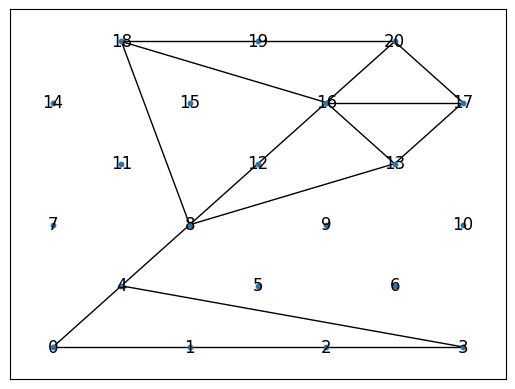

In [ ]:
print(len(timeline))
gif_gen_new("test.gif",timeline,pos)

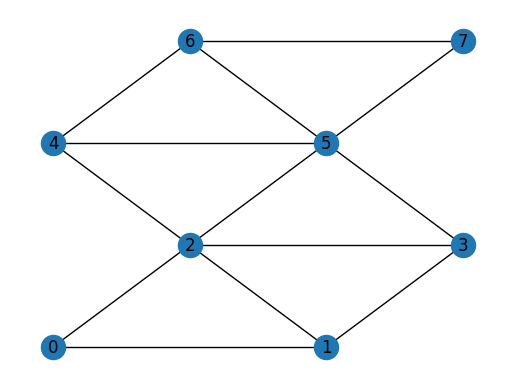

[[1.2 1.2 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.4 0.  0.  0.  0.4 0.  0.  0. ]
 [0.1 0.  0.  0.  0.  0.1 0.  0. ]
 [0.1 0.  0.  0.  0.  0.1 0.  0. ]
 [0.  0.  0.  0.  0.4 0.4 0.  0. ]
 [0.  0.  0.  0.  0.4 0.  0.4 0. ]
 [0.  0.  0.  0.  0.  0.1 0.  0.1]
 [0.  0.  0.  0.  0.  0.1 0.1 0. ]
 [0.  0.  0.  0.  0.  0.  0.4 0.4]]


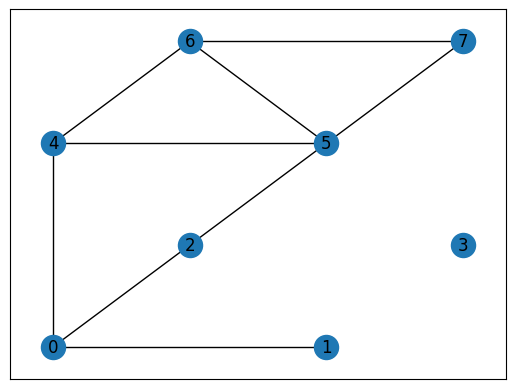

In [ ]:

edges = dict(triag.edges())
nodes = list(triag.nodes())

posl = list(triag.nodes.data("pos"))
pos = dict((it, p[1]) for it, p in enumerate(posl))

A = adjacency_matrix(nodes, edges)
D = A * 0.1

draw(edges_to_nodes(A), pos)
timeline = loop(D, pos, ntimes=10, step=0.3)
gif_gen_new("test.gif", timeline, pos)

print(timeline[-1])


105

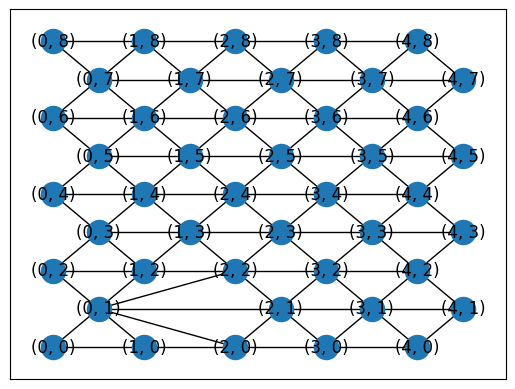

In [ ]:
egdes_c = {((0,1),(1,1)),((1,1),(2,1))}#,((0,1),(3,1)),((0,1),(4,1))}
triag_c = triag


for e in egdes_c:
  triag_c = nx.contracted_edge(triag,e,self_loops=False)
pos = dict(triag.nodes.data("pos"))
nx.draw_networkx(triag_c,pos=pos)
len(list(triag_c.edges()))

In [ ]:
def edge_len(e,npos):
  pos = dict(npos)
  liste = list(e)
  llist =[]
  for i in liste:
    li = (pos[i[0]][0]-pos[i[1]][0])**2
    li += (pos[i[0]][1]-pos[i[1]][1])**2
    llist.append(np.sqrt(li))
  return llist

def add_attributes(lattice,d=0.2):
  liste = list(lattice.edges())
  llist = edge_len(lattice.edges(),lattice.nodes.data("pos"))
  for ei,l in zip(liste, llist):
    lattice.edges[ei[0],ei[1]]['lenght'] = l
    lattice.edges[ei[0],ei[1]]['d'] = d
  return lattice

def update_length(lattice):
  liste = list(lattice.edges())
  llist = edge_len(lattice.edges(),lattice.nodes.data("pos"))
  for ei,l in zip(liste, llist):
    lattice.edges[ei[0],ei[1]]['lenght'] = l
  return lattice

def update_d(lattice,d,e_id):
  lattice.edges[e_id[0],e_id[1]]['d'] = d
  return lattice

def update_pos(lattice,e_id,pos,diameters):
  d0=diameters[0]
  d1=diameters[1]
  d=d0+d1
  pos0=pos[0]*d0+pos[2]*d1
  pos1=pos[1]+pos[3]
  final_pos  = (pos0/2/d,pos1/2)
  lattice.nodes[e_id[0]]['pos'] = final_pos
  return lattice

def update_latt(latt,d,nm,e_id):
  lattice = update_d(latt,d,e_id)
  pos = lattice.nodes.data('pos')[nm[0]] + lattice.nodes.data('pos')[nm[1]]
  diameters = (lattice.edges[e_id[0],e_id[1]]['d'], lattice.edges[nm[0],nm[1]]['d'])
  lattice = nx.contracted_edge(lattice,nm,self_loops=False)
  lattice = update_pos(lattice,nm,pos,diameters)
  lattice = update_d(lattice,d,e_id)
  #if lattice.number_of_edges()<10:
   # lattice = check_and_add(lattice)
  return update_length(lattice)

In [ ]:
def random_add(e,eps):
  liste = list(e)
  max = len(e)-1
  i  = random.randint(0, max)
  while liste[i][0][1] == liste[i][1][1]:
    i  = random.randint(0, max)
  e[liste[i]]["d"] += eps
  return (e,liste[i])

def merge(neighbors, e, e_id):
  d = e[e_id]['d']
  Nmerge = []
  for n in neighbors:
    if n[0] == e_id[1][1]:
      break
    dn0 = e[e_id[0],n]['d']
    dn1 = e[e_id[1],n]['d']
    l0 = e[e_id[0],n]['lenght']
    l1 = e[e_id[1],n]['lenght']
    e0 = (e_id[0],n)
    e1 = (e_id[1],n)
    if dn0+d>= l1 and dn0>dn1:
      Nmerge.append((e1,dn0+d))
    if dn1+d>=l0 and dn0<=dn1:
      Nmerge.append((e0,dn1+d))
  return (len(Nmerge)>0, Nmerge)

def check_and_add(lattice):
  print("checking")
  for n in lattice.nodes():
    neighbors = list(lattice.neighbors(n))
    if len(neighbors)==1:
      for nn in lattice.neighbors(neighbors[0]):
        if nn != n:
          print('adding')
          lattice.add_edge(n,nn,d=0.1)
  return lattice

def contracting_loop(lattice,n,eps=0.2):
  c=0
  latt_list = []
  latt_list.append(lattice)
  for i in range(n):
    e, e_id = random_add(lattice.edges(),eps)
    neighbors = nx.common_neighbors(lattice,e_id[0],e_id[1])
    boolmerge, Nmerge = merge(neighbors, e, e_id)
    if boolmerge:
      for nm,d in Nmerge:
        lattice = update_latt(lattice,d,nm,e_id)
        latt_list.append(lattice)
        c+=1
    elif lattice.number_of_edges()==8:
      break
  print(f"Initial number of edges  {latt_list[0].number_of_edges()}")
  print(f"contracted {c} edges in {i+1} steps")
  print(f"Final number of edges {lattice.number_of_edges()}")
  return (lattice, latt_list,c+1)

triag = add_attributes(triag)
triag_cont = triag
triag_cont, latt_list, num_plots = contracting_loop(triag_cont,n=6000,eps=0.2)

Initial number of edges  108
contracted 36 edges in 150 steps
Final number of edges 8


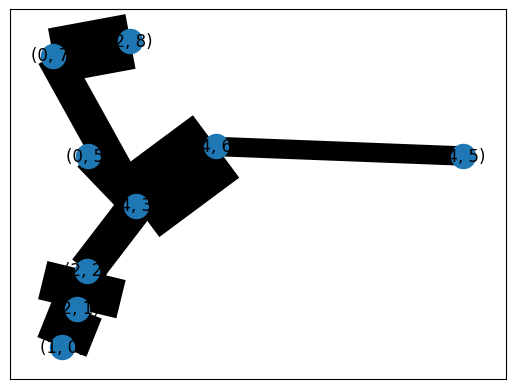

In [ ]:
def gif_gen(fp,latt_list):
  fig, ax = plt.subplots()
  def init():
      ax.clear()
  def update(i):
      ax.clear()
      G = latt_list[i]
      d = nx.get_edge_attributes(G,'d').values()
      scale=10
      d=list(map(lambda x:x*scale,d))
      nx.draw_networkx(G, pos=latt_list[i].nodes.data("pos"), ax=ax,width=list(d))#uncomment to add visual widths
  ani = FuncAnimation(fig, update, frames=num_plots, init_func=init, repeat=False)
  ani.save(fp, writer="pillow", fps=1.5)
gif_gen("widths_regular.gif",latt_list)